In [117]:
import numpy as np
import torch
import math
!pip install gpytorch
!pip install adabound
import gpytorch
from gpytorch.kernels.rbf_kernel import postprocess_rbf
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from collections import OrderedDict
import copy
import adabound

In [96]:

def function(X,noise=0):
  def func(x):
    return (math.pow((x[1]-5.1/(4*math.pow(3.14,2))*math.pow(x[0],2)+5/3.14*x[0]-6),2)+10*(1-1/(8*3.14))*math.cos(x[0])+10)*math.sin(x[2]/5)
  return torch.tensor(np.apply_along_axis(func, 1, X).reshape(-1,1),dtype = torch.float32)

batch_shape = torch.Size([1])
a1 = torch.linspace(-5, 10, 4)
a2 = torch.linspace(0, 15, 4)
a3 = torch.linspace(-5,5,4)
train_x = torch.zeros((4*4*4,3),dtype=torch.float32)
ctr=0
for i1 in a1:
    for i2 in a2:
        for i3 in a3:
            train_x[ctr,0] = i1
            train_x[ctr,1] = i2
            train_x[ctr,2] = i3
            ctr+=1

def get_proj_matrix(D,d,hypersphere=0):
  ''' Takes three arguments D : column size, d : row size and hypersphere = 0/1 (if hypersphere is 1 then sample each row of B from S^{D-1} else from N(0,1))
  returns a random B matrix of shape d x D '''
  A = np.random.normal(0,1,(d,D))
  if hypersphere==1:
    for row in range(d):
      N = np.linalg.norm(A[row,:])
      A[row,:] = A[row,:]/N
  return A

B = torch.tensor(get_proj_matrix(3,2,1),dtype=torch.float32)
train_x_d = (train_x @ B.t())
train_y = function(train_x)
train_y = train_y.squeeze(1)




class AleboKernel(gpytorch.kernels.Kernel):
  ''' creates instances of alebo kernel in which distance metric is mahalonobis instead of euclidean distance.'''
  def __init__(self,B):
    super().__init__(has_length=False,ard_num_dims=None,eps=0.0)
    self.d = B.shape[0]
    self.D = B.shape[1]
    self.B = B
    self.Binv = torch.pinverse(B)
    # self.dtype = B.dtype
    # self.batch_shape = batch_shape

    A = torch.qr(torch.randn(self.D,self.D))[0]
    ABinv = A[:self.d,:] @ self.Binv
    T = ABinv.t() @ ABinv
    U = torch.cholesky(T,upper = True)
    self.idx = U.nonzero().t().tolist()
    Uvec = U[self.idx]#.repeat(*batch_shape,1)
    # print(Uvec)
    t = torch.tensor(2.0)
    self.register_parameter(name = "Uvec",parameter=torch.nn.Parameter(Uvec))


    
  def forward(self,x1,x2,**params):
    U_t = torch.zeros(self.Uvec.shape[:-1]+torch.Size([self.d,self.d]))
    U_t[...,self.idx[1],self.idx[0]] = self.Uvec
    z1 = x1 @ U_t
    z2 = x2 @ U_t
    return self.covar_dist(z1,z2,square_dist=True,dist_postprocess_func=postprocess_rbf,postprocess=True,**params)

class AleboGP(gpytorch.models.ExactGP):
  ''' Creates instance of Alebo GP by taking into account the mahalonobis kernel '''
  def __init__(self, train_x, train_y, likelihood,B):
    super().__init__(train_x, train_y, likelihood)
    self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel=AleboKernel(B=B))
    self.mean_module = gpytorch.means.ConstantMean()
  def forward(self,x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




In [111]:

def calc_grad(model,likelihood,train_x,train_y):
  model.train()
  likelihood.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=.01)
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  optimizer.zero_grad()
  output = model(train_x)
  loss = -mll(output, train_y).sum()
  loss.backward()
  optimizer.step()
  
  model.eval()
  likelihood.eval()
  return model.covar_module.base_kernel.Uvec.grad

def train(model,likelihood,train_x,train_y,training_iter=4000):
  ''' Takes model and training data and return the optimised parameter of the AleboGP model'''
# training_iter = 50
  model.train()
  likelihood.train()
  print(model.parameters())
  for params in model.parameters():
    print(params)
  # optimizer = adabound.AdaBound(model.parameters(), lr=1.6,final_lr = 0.05)
  optimizer = torch.optim.Adam(model.parameters(), lr=.01) 

  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


  for i in range(training_iter):
      optimizer.zero_grad()
      output = model(train_x)
  
      loss = -mll(output, train_y).sum()
      loss.backward()
      optimizer.step()
      params_dict = OrderedDict(mll.named_parameters())
      # print(loss)
      # print(params_dict)
      # print(model.covar_module.base_kernel.)
      # if i in [0,1]:
        # for param_name, attr in params_dict.items():
        #   print(param_name)
        #   print(params_dict[param_name])
        # print(params_dict[param_name].requires_grad)

  
  model.eval()
  likelihood.eval()

  return model,likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = AleboGP(train_x_d, train_y, likelihood,B)

model,likelihood = train(model,likelihood,train_x_d,train_y)

<generator object Module.parameters at 0x7f6382cb0550>
Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor(0., requires_grad=True)
Parameter containing:
tensor([1.3049, 0.6363, 0.6967], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [ ]:
def get_r2_square(model,likelihood,train_x,train_y):
  ''' takes mode and training data and calculates r2 square score for of the model on the data'''
  observed_pred = likelihood(model(train_x))
  lower,upper = observed_pred.confidence_region()
  r2_square = 0
  sum_diff = 0
  for i in range(train_x.shape[0]):
    r2_square += (observed_pred.mean[i].detach().numpy()-train_y[i].numpy())**2
  sum_diff += np.sum(upper.detach().numpy())-np.sum(lower.detach().numpy())

  return r2_square,sum_diff
    
def get_best_fit_gp(train_x,train_y,n_trials=3):
  ''' generates and train n_trials number of models and return the model that fits the data in the best way by using r2 square metric. '''
  ## Use MLL if it gives poor result.
  best_state = {}
  r2_square = 1e9
  for i in range(n_trials):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = AleboGP(train_x, train_y, likelihood,B)

    model,likelihood = train(model,likelihood,train_x,train_y)

    r2_square_i,sum_diff_i = get_r2_square(model,likelihood,train_x,train_y)

    if r2_square_i < r2_square:
      best_state = model.state_dict()
      r2_square = r2_square_i
  
  best_likelihood =gpytorch.likelihoods.GaussianLikelihood()
  best_model = AleboGP(train_x, train_y, likelihood,B)
  best_model.state_dict(best_state)

  return best_likelihood,best_model


# def sample_U(likelihood,model,nsamp=10):
  # return list of Uvec for each model
likelihood, model = get_best_fit_gp(train_x @ B.t(),train_y)



In [ ]:
model.eval()
likelihood.eval()

observed_pred = likelihood(model(train_x @ B.t()))
lower,upper = observed_pred.confidence_region()


plt.plot(train_y, observed_pred.mean.detach().numpy(),'bo' ,label="Pred")
plt.plot(train_y,train_y,label='Ideal')
plt.legend()

In [ ]:
def double_derivative(i,epsilon_i,m1,m2,l1,l2,train_x,train_y):
    '''Function which takes the models m1 and m2 (m2 is for m1+epsilon)
        and returns the double derivative for i-th component'''
    g1 = (m1.covar_module.base_kernel.Uvec.grad)
    g2 = calc_grad(m2,l2,train_x,train_y)
    return (g2[i] - g1[i])/epsilon_i


def print_param(model):
  print()
  for x in model.named_parameters():
      print(x)
  print()

def update_Uvec(model,likelihood,i,ep):
  ''' updates the ith element of Uvec model parameter from Uvec[i] to Uvec[i]+ep and returns the model with updated parameters'''
  model_copy = copy.deepcopy(model)
  print_param(model_copy)
  Uvec = model_copy.covar_module.base_kernel.Uvec
  model_copy.covar_module.base_kernel.Uvec.requires_grad_(False)
  Uvec[i] = Uvec[i]+ep
  model_copy.covar_module.base_kernel.Uvec.requires_grad_(True)
  print_param(model_copy)

  return model_copy,likelihood


def sample_U(model,likelihood,train_x,train_y,n=5):
  '''Takes best fit model and return n model where each model's Uvec is sampled from laplace approx of MAP model(model,likelihood)'''
  Uvec = model.covar_module.base_kernel.Uvec
  mean_constant = model.mean_module.constant
  output_scale = model.covar_module.raw_outputscale
  noise_covar = model.likelihood.noise_covar.raw_noise

  hessian = np.zeros((Uvec.shape[0],Uvec.shape[0]))
  ep = 1e-3 * np.abs(Uvec.detach().numpy()) + 1e-4
  for j in range(Uvec.shape[0]):
    m2,l2 = update_Uvec(model,likelihood,j,ep[j])
    hessian[j,j] = double_derivative(j,ep[j],model,m2,likelihood,l2,train_x,train_y)
  
  print(hessian)
  Sigma = np.linalg.inv(-hessian)
  samples = np.random.multivariate_normal(mean=Uvec.detach().numpy(), cov=Sigma, size=(n - 1))
  

  m_list = [model]
  l_list = [likelihood]

  for i in range(n-1):
    new_model = copy.deepcopy(model)
    new_likelihood = copy.deepcopy(likelihood)
    new_model.train()
    

    new_Uvec = torch.tensor(samples[i])
    new_model.covar_module.base_kernel.Uvec.requires_grad_(False)
    new_model.covar_module.base_kernel.Uvec.copy_(new_Uvec)
    new_model.covar_module.base_kernel.Uvec.requires_grad_(False)

    new_model.eval()
    new_model,new_likelihood = train(new_model,new_likelihood,train_x,train_y)

    m_list.append(new_model)
    l_list.append(new_likelihood)

  
  return m_list,l_list



m_list,l_list = sample_U(model,likelihood,train_x @ B.t(),train_y)



# update_Uvec(model,likelihood,0,torch.tensor(1))



/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


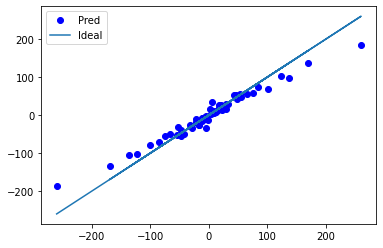

In [121]:
def get_final_pred(models,likelihoods,test_x): # test_x is in n*d dimensions.returns means,variances
    preds = [likelihood(model(test_x)) for likelihood,model in zip(likelihoods,models)]
    means = torch.tensor([[y.mean for y in x] for x in preds]).t()
    variances = torch.tensor([[y.variance for y in x] for x in preds]).t()
    mu = torch.mean(means,axis=1)
    variance = torch.mean(variances,axis=1) + torch.var(means,axis=1,unbiased=False)
    return mu,variance

model.eval()
likelihood.eval()

# observed_pred = likelihood(model(train_x @ B.t()))
# lower,upper = observed_pred.confidence_region()
y_pred,_ = get_final_pred(m_list,l_list,train_x_d)

plt.plot(train_y, y_pred,'bo' ,label="Pred")
plt.plot(train_y,train_y,label='Ideal')
plt.legend()

In [118]:
def constrained_minimize(objective,Binv,x0):
    def constraint_generator_minus_1(Binv,i):
        def con(x):
            x_D = Binv @ x
            return x_D[i]+1
        return con
    def constraint_generator_plus_1(Binv,i):
        def con(x):
            x_D = Binv @ x
            return 1-x_D[i]
        return con
    constraints_fun = []
    for i in range(B.shape[0]):
        constraints_fun.append(constraint_generator_minus_1(Binv,i))
        constraints_fun.append(constraint_generator_plus_1(Binv,i))
    constraints = [{'type':'ineq', 'fun':fun} for fun in constraints_fun]
    print(constraints)
    candidate = minimize(objective,x0,constraints=constraints,method='SLSQP')
    return candidate
            


def objective(x):
    print("x=",x)
    return x.sum()
B = np.eye(3)
x0 = np.array([0.5,0.5,0.5])
constrained_minimize(objective,B,x0)

[{'type': 'ineq', 'fun': <function constrained_minimize.<locals>.constraint_generator_minus_1.<locals>.con at 0x7f636f28fe60>}, {'type': 'ineq', 'fun': <function constrained_minimize.<locals>.constraint_generator_plus_1.<locals>.con at 0x7f636f28fb00>}, {'type': 'ineq', 'fun': <function constrained_minimize.<locals>.constraint_generator_minus_1.<locals>.con at 0x7f636f28f8c0>}, {'type': 'ineq', 'fun': <function constrained_minimize.<locals>.constraint_generator_plus_1.<locals>.con at 0x7f636f28f830>}, {'type': 'ineq', 'fun': <function constrained_minimize.<locals>.constraint_generator_minus_1.<locals>.con at 0x7f636f28fdd0>}, {'type': 'ineq', 'fun': <function constrained_minimize.<locals>.constraint_generator_plus_1.<locals>.con at 0x7f636f28fef0>}]
x= [0.5 0.5 0.5]
x= [0.5 0.5 0.5]
x= [0.50000001 0.5        0.5       ]
x= [0.5        0.50000001 0.5       ]
x= [0.5        0.5        0.50000001]
x= [-0.5 -0.5 -0.5]
x= [-0.5 -0.5 -0.5]
x= [-0.49999999 -0.5        -0.5       ]
x= [-0.5   

     fun: -3.0000000000000133
     jac: array([1., 1., 1.])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([-1., -1., -1.])